# Week 1: Loading and Exploring NWB Data

This notebook introduces how to load and explore neural data stored in the
[Neurodata Without Borders (NWB)](https://www.nwb.org/) format.

We'll use a dataset from the Buzsaki Lab containing hippocampal recordings
during spatial navigation.

**Dataset**: MS22 - Peter-MS22-180629
**DANDI Archive**: [DANDI:000059](https://dandiarchive.org/dandiset/000059)

## Setup

First, let's import the necessary libraries.

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from dandi.dandiapi import DandiAPIClient
from pynwb import NWBHDF5IO
from remfile import File as RemoteFile

## Streaming Data from DANDI

We can stream data directly from DANDI without downloading the entire file.
This is useful for exploring large datasets without waiting for downloads.

In [2]:
# Define the dataset location on DANDI
DANDISET_ID = "000059"
DANDISET_VERSION = "0.230907.2101"
ASSET_PATH = (
    "sub-MS22/"
    "sub-MS22_ses-Peter-MS22-180629-110319-concat_desc-processed_behavior+ecephys.nwb"
)

In [3]:
# Connect to DANDI and get the streaming URL
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(DANDISET_ID, DANDISET_VERSION)
    asset = dandiset.get_asset_by_path(ASSET_PATH)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

print(f"Streaming from: {s3_url[:80]}...")

Streaming from: https://dandiarchive.s3.amazonaws.com/blobs/075/b32/075b32be-1c44-4e2f-8a91-3eeb...


In [4]:
# Open the NWB file for streaming (no download required)
remote_file = RemoteFile(s3_url)
h5_file = h5py.File(remote_file, "r")
io = NWBHDF5IO(file=h5_file, load_namespaces=True)
nwbfile = io.read()

print(f"Session: {nwbfile.identifier}")
print(f"Description: {nwbfile.session_description}")

Session: 7931d1a7-09c5-457f-9f0a-22d952d8b818
Description: Petersen et al. demonstrate that cooling of the medial septum slows theta oscillation and increases choice errors without affecting spatial features of pyramidal neurons. Cooling affects distance-time, but not distance-theta phase, compression. The findings reveal that cell assemblies are organized by theta phase and not by external (clock) time.


## Exploring the NWB File Structure

NWB files are organized hierarchically. Let's explore what data is available.

In [5]:
# Session metadata
print("Session Information")
print("-" * 40)
print(f"Session ID:    {nwbfile.identifier}")
print(f"Start time:    {nwbfile.session_start_time}")
print(f"Experimenter:  {nwbfile.experimenter}")
print(f"Lab:           {nwbfile.lab}")
print(f"Institution:   {nwbfile.institution}")

Session Information
----------------------------------------
Session ID:    7931d1a7-09c5-457f-9f0a-22d952d8b818
Start time:    2018-06-29 11:03:19-04:00
Experimenter:  ('Michelle Hernandez', 'Peter Petersen')
Lab:           Buzsaki
Institution:   NYU


In [6]:
# List available processing modules and their interfaces
print("\nProcessing Modules")
print("-" * 40)

# Use dictionary comprehension to build a summary
module_contents = {
    module_name: list(module.data_interfaces.keys())
    for module_name, module in nwbfile.processing.items()
}

for module_name, interfaces in module_contents.items():
    print(f"\n{module_name}:")
    print(f"  {interfaces}")


Processing Modules
----------------------------------------

behavior:
  ['Acceleration', 'SubjectPosition', 'SubjectSpeed', 'Temperature']


In [7]:
# Check for sorted units (spike-sorted neurons)
print("\nUnits (Sorted Spikes)")
print("-" * 40)
if nwbfile.units is not None:
    n_units = len(nwbfile.units)
    print(f"Number of units: {n_units}")
    print(f"Available columns: {list(nwbfile.units.colnames)}")
else:
    print("No units table found")


Units (Sorted Spikes)
----------------------------------------
Number of units: 1509
Available columns: ['quality', 'spike_times', 'pc_features', 'amplitudes']


## Visualizing Spike Times

A spike raster plot shows when each neuron fires. We use `matplotlib.pyplot.eventplot`,
which is designed specifically for visualizing event times like spikes.

In [8]:
# Extract spike times for a subset of units
N_UNITS_TO_PLOT = 10
TIME_WINDOW = (0, 60)  # First 60 seconds


def get_spike_times_in_window(units_table, unit_idx, time_window):
    """Extract spike times for a unit within a time window.

    Parameters
    ----------
    units_table : pynwb.misc.Units
        NWB units table containing spike times
    unit_idx : int
        Index of the unit to extract
    time_window : tuple of float
        (start_time, end_time) in seconds

    Returns
    -------
    np.ndarray
        Spike times within the window
    """
    spikes = units_table["spike_times"][unit_idx]
    mask = (spikes >= time_window[0]) & (spikes <= time_window[1])
    return spikes[mask]

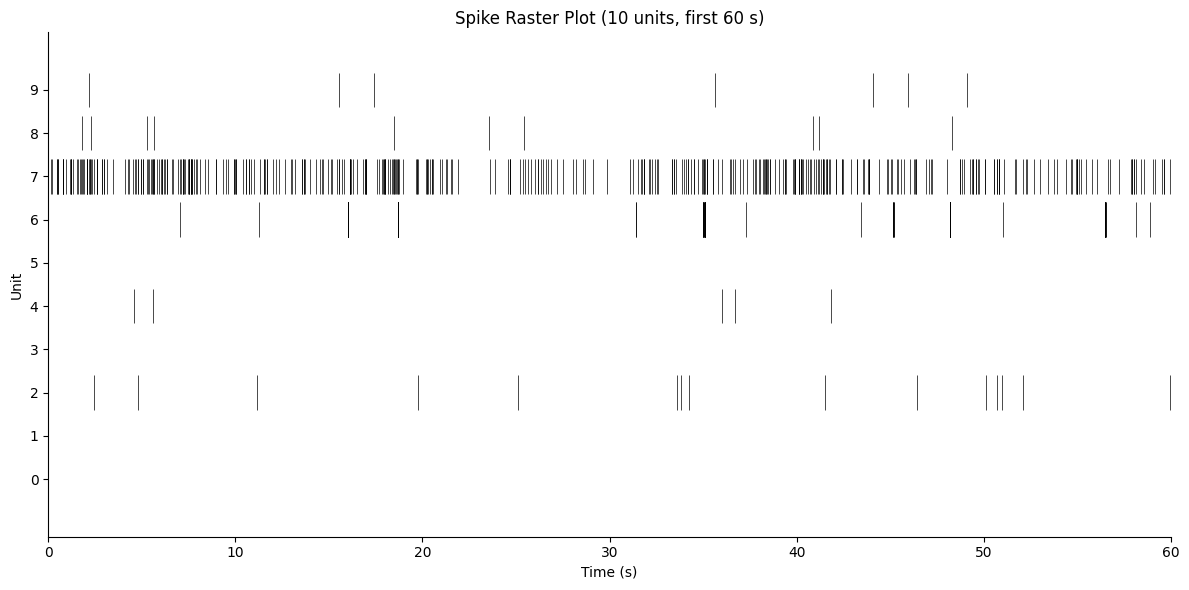

In [9]:
if nwbfile.units is not None:
    n_units = min(N_UNITS_TO_PLOT, len(nwbfile.units))

    # Use list comprehension to collect spike times
    spike_times_list = [
        get_spike_times_in_window(nwbfile.units, i, TIME_WINDOW) for i in range(n_units)
    ]

    # Create raster plot using eventplot
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.eventplot(
        spike_times_list,
        lineoffsets=np.arange(n_units),
        linelengths=0.8,
        linewidths=0.5,
        colors="black",
    )

    ax.set(
        xlabel="Time (s)",
        ylabel="Unit",
        xlim=TIME_WINDOW,
        yticks=np.arange(n_units),
        title=f"Spike Raster Plot ({n_units} units, first {TIME_WINDOW[1]} s)",
    )

    # Remove top and right spines for cleaner look
    ax.spines[["top", "right"]].set_visible(False)

    plt.tight_layout()
    plt.show()

## Extracting Position Data

For navigation studies, we need the animal's position over time. Position data
is typically stored in the "behavior" processing module.

In [10]:
# Find position data in the behavior module
behavior_module = nwbfile.processing.get("behavior")

if behavior_module is not None:
    print("Available behavior interfaces:")
    print(f"  {list(behavior_module.data_interfaces.keys())}")

Available behavior interfaces:
  ['Acceleration', 'SubjectPosition', 'SubjectSpeed', 'Temperature']


In [11]:
# Extract position data using next() with a generator expression
position_interface = None
if behavior_module is not None:
    # Find first interface with "position" in the name (case-insensitive)
    position_interface = next(
        (
            interface
            for name, interface in behavior_module.data_interfaces.items()
            if "position" in name.lower()
        ),
        None,
    )

    if position_interface is not None:
        print(f"Found position interface: {type(position_interface).__name__}")

        # Get info about each spatial series
        for series_name, spatial_series in position_interface.spatial_series.items():
            print(f"\nSpatial series: {series_name}")
            print(f"  Data shape: {spatial_series.data.shape}")
            rate_info = (
                f"{spatial_series.rate} Hz"
                if spatial_series.rate
                else f"{len(spatial_series.timestamps)} timestamps"
            )
            print(f"  Sampling: {rate_info}")

Found position interface: Position

Spatial series: SpatialSeries
  Data shape: (198664, 3)
  Sampling: 198664 timestamps


## Visualizing the Animal's Trajectory

Let's plot the animal's path through the environment.

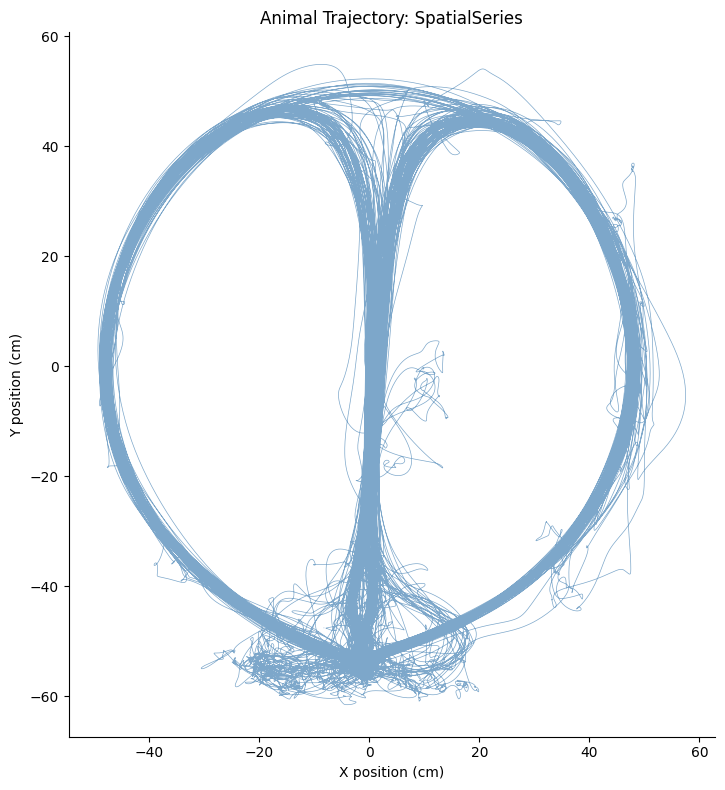

In [12]:
if position_interface is not None:
    # Get the first spatial series with 2D data
    spatial_series = next(iter(position_interface.spatial_series.values()))
    position_data = spatial_series.data[:]

    if position_data.ndim == 2 and position_data.shape[1] >= 2:
        # Unpack x and y coordinates
        x_position, y_position = position_data[:, 0], position_data[:, 1]

        fig, ax = plt.subplots(figsize=(8, 8))

        ax.plot(x_position, y_position, linewidth=0.5, alpha=0.7, color="steelblue")

        ax.set(
            xlabel="X position (cm)",
            ylabel="Y position (cm)",
            title=f"Animal Trajectory: {spatial_series.name}",
            aspect="equal",
        )

        ax.spines[["top", "right"]].set_visible(False)

        plt.tight_layout()
        plt.show()

## Downloading Data Locally (Optional)

For repeated use or offline access, you can download the data:

```bash
pip install dandi
dandi download DANDI:000059/0.230907.2101 --path sub-MS22
```

Then load with:

```python
with NWBHDF5IO("path/to/file.nwb", "r") as io:
    nwbfile = io.read()
    # Work with nwbfile...
```

## Cleanup

In [13]:
# Always close the file when done
io.close()

## Summary

In this notebook, we learned how to:

1. **Stream NWB data from DANDI** without downloading large files
2. **Explore NWB file structure** to discover available data
3. **Extract and visualize spike times** using `eventplot` for raster plots
4. **Extract and visualize position data** for navigation analysis

### Key Functions

| Function | Purpose |
|----------|---------|
| `DandiAPIClient()` | Connect to DANDI archive |
| `NWBHDF5IO()` | Read NWB files |
| `plt.eventplot()` | Create spike raster plots |
| `nwbfile.units` | Access sorted spike data |
| `nwbfile.processing` | Access processed data (behavior, etc.) |

### Python Best Practices Used

- **List/dict comprehensions** instead of explicit for loops
- **`next()` with generators** for finding first matching item
- **`.get()` method** for safe dictionary access
- **`ax.set()`** for setting multiple axes properties at once
- **Tuple unpacking** for readable coordinate extraction
- **Docstrings** for function documentation

In the next notebook, we'll analyze the relationship between neural activity
and the animal's position.